In [1]:
from IPython.display import display, HTML


display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# !pip3 install torch_geometric
!pip3 install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from single_graph_construction_approach import single_graph_construction
from synthetic_graph import convert_networkx_to_pyg
from cl import train_model
import torch
from pylab import rcParams


rcParams['figure.figsize'] = 25, 2.5

In [4]:
#

In [5]:
num_samples = 16384
num_features = 8

X = np.random.rand(num_samples, num_features)
coefficients = np.random.rand(num_features)

y = X.dot(coefficients)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.75)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50)

In [7]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [8]:
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)
print('Validation set: ', X_val.shape, y_val.shape)

Train set:  (12288, 8) (12288,)
Test set:  (2048, 8) (2048,)
Validation set:  (2048, 8) (2048,)


In [9]:
#

In [10]:
print('Constructing G_train')
G_train = single_graph_construction(X_train, n_neighbors=8)

print('Constructing G_validation')
G_validation = single_graph_construction(X_val, n_neighbors=8)

print('Constructing G_test')
G_test = single_graph_construction(X_test, n_neighbors=8)

Constructing G_train
Constructing G_validation
Constructing G_test


In [11]:
model = train_model(G_train=G_train, G_validation=G_validation, out_channels=16)

C:\_work\graph_performance_embeddings\lib\site-packages\torch_geometric\utils\convert.py:260: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  data[key] = torch.tensor(value)
C:\_work\graph_performance_embeddings\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


Epoch: 1, Train Loss: 8.296870231628418, Val Loss: 5.9571757316589355
Epoch: 2, Train Loss: 7.4426798820495605, Val Loss: 5.570206165313721
Epoch: 3, Train Loss: 6.973114490509033, Val Loss: 4.978651523590088
Epoch: 4, Train Loss: 6.558297634124756, Val Loss: 4.6082234382629395
Epoch: 5, Train Loss: 6.136484146118164, Val Loss: 4.239538669586182
Epoch: 6, Train Loss: 5.771861553192139, Val Loss: 4.015406131744385
Epoch: 7, Train Loss: 5.548708438873291, Val Loss: 3.732728958129883
Epoch: 8, Train Loss: 5.32700252532959, Val Loss: 3.723797082901001
Epoch: 9, Train Loss: 5.171746253967285, Val Loss: 3.659212112426758
Epoch: 10, Train Loss: 5.075957298278809, Val Loss: 3.455040693283081
Epoch: 11, Train Loss: 5.015131950378418, Val Loss: 3.5598134994506836
Epoch: 12, Train Loss: 4.965322017669678, Val Loss: 3.380821943283081
Epoch: 13, Train Loss: 4.886703014373779, Val Loss: 3.373566150665283
Epoch: 14, Train Loss: 4.82982063293457, Val Loss: 3.3454856872558594
Epoch: 15, Train Loss: 4.7

Epoch: 117, Train Loss: 3.708376884460449, Val Loss: 2.3115360736846924
Epoch: 118, Train Loss: 3.687690019607544, Val Loss: 2.3126611709594727
Epoch: 119, Train Loss: 3.695298194885254, Val Loss: 2.3491146564483643
Epoch: 120, Train Loss: 3.699101448059082, Val Loss: 2.3066117763519287
Epoch: 121, Train Loss: 3.670861005783081, Val Loss: 2.33760404586792
Epoch: 122, Train Loss: 3.6794073581695557, Val Loss: 2.3499515056610107
Epoch: 123, Train Loss: 3.6945321559906006, Val Loss: 2.328930377960205
Epoch: 124, Train Loss: 3.666229248046875, Val Loss: 2.338587999343872
Epoch: 125, Train Loss: 3.6659257411956787, Val Loss: 2.311631441116333
Epoch: 126, Train Loss: 3.666057586669922, Val Loss: 2.3199124336242676
Epoch: 127, Train Loss: 3.6664483547210693, Val Loss: 2.287238359451294
Epoch: 128, Train Loss: 3.651259183883667, Val Loss: 2.3254501819610596


In [12]:
with torch.no_grad():
    output = convert_networkx_to_pyg(G_test, feature_key='features')
    output = model(output.x, output.edge_index).cpu().numpy()

In [13]:
output

array([[-0.5485084 , -0.419432  ,  0.26395088, ..., -0.14829238,
        -0.17089432, -0.03522058],
       [ 0.03910124,  0.29590836, -0.14206903, ...,  0.05155313,
        -0.11578859,  0.11634858],
       [ 0.40401995,  0.16919678,  0.43248257, ...,  0.01236147,
         0.18967327,  0.03801519],
       ...,
       [-0.21985757,  0.11428983, -0.18426982, ...,  0.14622827,
        -0.27523315, -0.04854512],
       [-0.18164545, -0.16415286, -0.0637383 , ...,  0.36746827,
        -0.48642635,  0.08968247],
       [ 0.04627097, -0.15297951, -0.20815594, ...,  0.00556035,
        -0.18334222,  0.06650338]], dtype=float32)

In [14]:
output.shape

(2048, 16)

Mean Squared Error: 0.013035198067411671


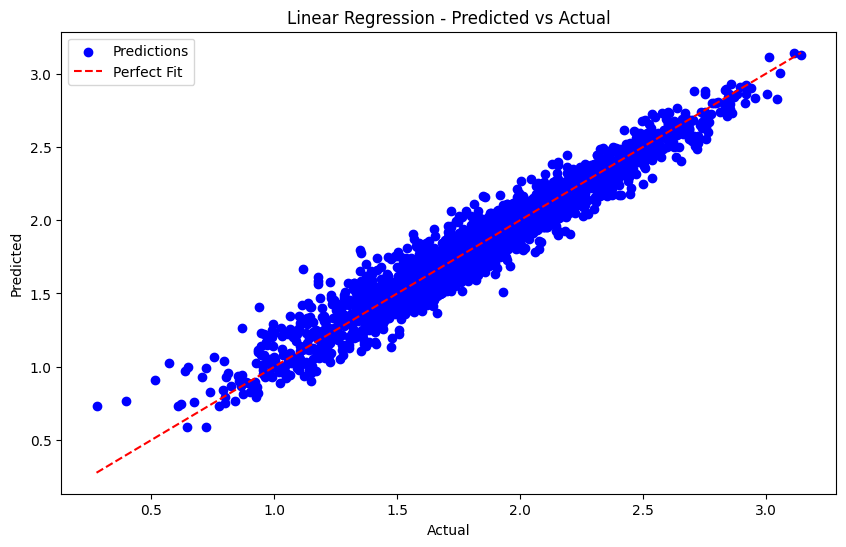

In [15]:
regressor = LinearRegression()
regressor.fit(output, y_test)
y_pred = regressor.predict(output)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.title('Linear Regression - Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()